*This assessment contains interactive plots. If you want to directly see the interactivity of some plots, then you need to download the jupyter notebook in your computer.*

## Data Source
The data source used is the <strong style="color: green">green</strong> taxi data for February 2016 from the following website: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (the files are stored in Parquet format).

In [1]:
# Download the data source
!mkdir data
!wget -P ./data/ https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2016-02.parquet 

--2024-09-19 19:10:55--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2016-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 108.138.245.225, 108.138.245.58, 108.138.245.96, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|108.138.245.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22771978 (22M) [application/x-www-form-urlencoded]
Saving to: ‘./data/green_tripdata_2016-02.parquet’

green_tripdata_2016 100%[===================>]  21.72M  7.74MB/s    in 2.8s    

2024-09-19 19:10:59 (7.74 MB/s) - ‘./data/green_tripdata_2016-02.parquet’ saved [22771978/22771978]



## Start of the Assessment

In [2]:
# automatically reload imported packages
%load_ext autoreload
%autoreload 2

# import all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller # test for stationarity
import statsmodels.api as sm
import numpy as np
import pytz
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from itertools import product # cartesian product for gridsearch

# import libraries that I created that may be useful in the future (who knows)
from forecasting.plotting import datetime_line_plot, count_comparison_bar_plot, comparison_line_plot

# other setup
from IPython.core.interactiveshell import InteractiveShell
import warnings

#allow multiple notebook displays without printing or `display`
InteractiveShell.ast_node_interactivity = "all"
#view all the columns when displayed in a notebook
pd.set_option('display.max_columns', None)
#set matplotlib default style
plt.style.use('ggplot')
warnings.filterwarnings("ignore") # not recommended but for this assessment only

In [3]:
# read the data
trip_data = pd.read_parquet('./data/green_tripdata_2016-02.parquet')

## 1. Report the number of rows and columns of the data.

In [4]:
num_rows, num_columns = trip_data.shape
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 1510722, Number of columns: 20


#### Data Exploration

In any machine learning or statistical modelling, the most important phase (at least for me) is the data exploration. In this phase, the understanding of the data should be established and documents related to the data should be provided (like data dictionary).

Even if the objective of the forecasting modelling is the to forecast the number of trips per hour. Having an access to a data dictionary is important.

I've tried to look at the data dictionary of the taxi data and found the following table:

|Field Name| Description|
|----------|------------|
|VendorID | A code indicating the LPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc.|
lpep_pickup_datetime | The date and time when the meter was engaged.|
lpep_dropoff_datetime | The date and time when the meter was disengaged.|
Passenger_count | The number of passengers in the vehicle. This is a driver-entered value.|
Trip_distance | The elapsed Trip Distance in Miles reported by the taximeter.|
PULocationID | TLC Taxi Zone in which the taximeter was engaged|
DOLocationID | TLC Taxi Zone in which the taximeter was disengaged|
RateCodeID | The final rate code in effect at the end of the trip. <br> 1= Standard rate <br> 2=JFK <br> 3=Newark <br> 4=Nassau or Westchester <br> 5=Negotiated fare <br> 6=Group ride
Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. <br> Y= store and forward trip <br> N= not a store and forward trip|
Payment_type | A numeric code signifying how the passenger paid for the trip. <br> 1= Credit card <br> 2= Cash <br>3= No charge <br>4= Dispute <br>5= Unknown<br> 6= Voided trip |
Fare_amount | The time-and-distance fare calculated by the meter.|
Extra | Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.|
MTA_tax | $0.50 MTA tax that is automatically triggered based on the metered rate in use.|
Improvement_surcharge | $0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015. |
Tip_amount | This field is automatically populated for credit card tips. Cash tips are not included.
Tolls_amount | Total amount of all tolls paid in trip. |
Total_amount | The total amount charged to passengers. Does not include cash tips. |
Trip_type | A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. <br>1= Street-hail <br>2= Dispatch

A few important points to note:

1. The distance is measured in miles. It might be easier to convert this to kilometers, as it's a metric unit and could provide a more intuitively precise measurement. <br>

2. There's no timezone specified in the data dictionary, but since this data is from NYC, I can assume the timezone is EST/US Time.<br>

    
Converting these two columns to their respective units/data types/timezone is important before to help us draw more accurate insights from our analysis.

Looking at the data information is also important to get familiar with the data:

In [5]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510722 entries, 0 to 1510721
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1510722 non-null  int64         
 1   lpep_pickup_datetime   1510722 non-null  datetime64[us]
 2   lpep_dropoff_datetime  1510722 non-null  datetime64[us]
 3   store_and_fwd_flag     1510722 non-null  object        
 4   RatecodeID             1510722 non-null  int64         
 5   PULocationID           1510722 non-null  int64         
 6   DOLocationID           1510722 non-null  int64         
 7   passenger_count        1510722 non-null  int64         
 8   trip_distance          1510722 non-null  float64       
 9   fare_amount            1510722 non-null  float64       
 10  extra                  1510722 non-null  float64       
 11  mta_tax                1510722 non-null  float64       
 12  tip_amount             15107

Two columns do not contain any data, and the trip_type has missing two data points.

<u>Normally, I am deleting the columns that do not contain any data. In ACSS(my current employer), we always make sure that this is well communicated to the clients, to let them be aware and for them to check if there are any errors in the data collection.</u>


Continuing, when working with a time-series data using pandas. I always use the datetime as a data index. It is more convenient in plotting and resampling:

In [6]:
# To have an easier time dealing with time-series data, I always use DateTimeIndex
trip_data = trip_data.set_index('lpep_pickup_datetime') # can also use inplace=True
trip_data.head()

,VendorID,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
lpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2016-02-01 00:11:39,2,2016-02-01 00:22:25,N,1,265,265,1,3.80,15.23,0.0,0.0,0.00,0.0,None,0.46,15.69,2,1.0,None
2016-02-01 00:44:47,2,2016-02-01 00:51:57,N,1,265,265,1,1.50,8.79,0.0,0.0,0.00,0.0,None,0.26,9.05,2,1.0,None
2016-02-01 00:10:55,2,2016-02-01 00:35:08,N,1,225,77,1,3.84,15.50,0.5,0.5,3.36,0.0,None,0.30,20.16,1,1.0,None
2016-02-01 00:36:25,2,2016-02-01 00:40:10,N,1,77,39,1,1.04,5.50,0.5,0.5,0.00,0.0,None,0.30,6.80,2,1.0,None
2016-02-01 00:06:28,2,2016-02-01 00:17:09,N,1,80,52,1,5.18,16.00,0.5,0.5,0.00,0.0,None,0.30,17.30,2,1.0,None


Making sure as well that we are in eastern timezone because the data is from NYC, convert the date-time index:

In [7]:
trip_data.index = trip_data.index.tz_localize(pytz.utc).tz_convert('US/Eastern')
trip_data.index.dtype

datetime64[us, US/Eastern]

Next is to convert miles to kilometers:

In [8]:
km_constant = 1.609344 # 1 mile  = 1.609344km

trip_data['trip_distance_km'] = trip_data['trip_distance'] * km_constant
trip_data[['trip_distance_km', 'trip_distance']].head()

,trip_distance_km,trip_distance
lpep_pickup_datetime,,
2016-01-31 19:11:39-05:00,6.115507,3.80
2016-01-31 19:44:47-05:00,2.414016,1.50
2016-01-31 19:10:55-05:00,6.179881,3.84
2016-01-31 19:36:25-05:00,1.673718,1.04
2016-01-31 19:06:28-05:00,8.336402,5.18


*For a non forecasting models, after reviewing the data dictionary, and consulting some concerns with the client, I always perform the univariate, bivariate, and multivariate analysis to the variables of interest.*

As the last step in exploring the data, I also add below the descriptive statistics:

In [9]:
trip_data.describe().T

,count,mean,min,25%,50%,75%,max,std
VendorID,1510722.0,1.785149,1.0,2.0,2.0,2.0,2.0,0.410719
lpep_dropoff_datetime,1510722,2016-02-15 20:54:57.890165,2016-02-01 00:01:04,2016-02-08 15:39:11.250000,2016-02-15 15:20:05,2016-02-22 22:50:14.250000,2016-03-01 23:47:15,NaN
RatecodeID,1510722.0,1.09133,1.0,1.0,1.0,1.0,99.0,0.613795
PULocationID,1510722.0,115.628077,1.0,49.0,92.0,179.0,265.0,77.320613
DOLocationID,1510722.0,129.730622,1.0,61.0,129.0,193.0,265.0,77.34236
passenger_count,1510722.0,1.352398,0.0,1.0,1.0,1.0,9.0,1.019621
trip_distance,1510722.0,2.733117,0.0,1.0,1.8,3.44,235.5,2.84441
fare_amount,1510722.0,11.748562,-400.0,6.0,9.0,14.5,933.5,9.39757
extra,1510722.0,0.349822,-4.5,0.0,0.5,0.5,4.5,0.381864
mta_tax,1510722.0,0.486959,-0.5,0.5,0.5,0.5,3.0,0.087901


This table presents a descriptive statistical summary of the data, allowing us to check for any irregularities, skewness, etc. For instance, a value of 999 might indicate an error. Fortunately, there doesn't appear to be any such errors in the data. However, we see that there's a negative fare, which is quite questionable.

## 2. Visualise the trip distance by time of day and report on any observations.

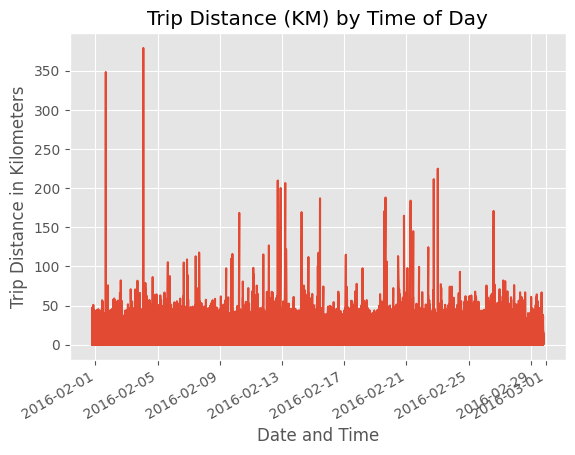

Figure 1: Trip Distance (KM) by Time of Day


In [10]:
# this code has been stored in the folder ./forecasting/plotting.py
datetime_line_plot(trip_data,
                   'trip_distance_km',
                   plot_title_name = 'Trip Distance (KM) by Time of Day', 
                   plot_xlabel_name= 'Date and Time', 
                   plot_ylabel_name= 'Trip Distance in Kilometers')
print("Figure 1: Trip Distance (KM) by Time of Day")

Without downsampling the data (averaging the trip distance per hour), we can see outliers in the first week of February. There are also longer trips in the middle of the month, which could mean that people tend to have longer trips on salary day/pay day (Assuming the payday are every 15th and 30th of the month), as stated in the NYC labor law: https://dol.ny.gov/frequency-pay, which mandates that clerical and other workers are paid at least twice per month.

Plotting the average hourly trip:

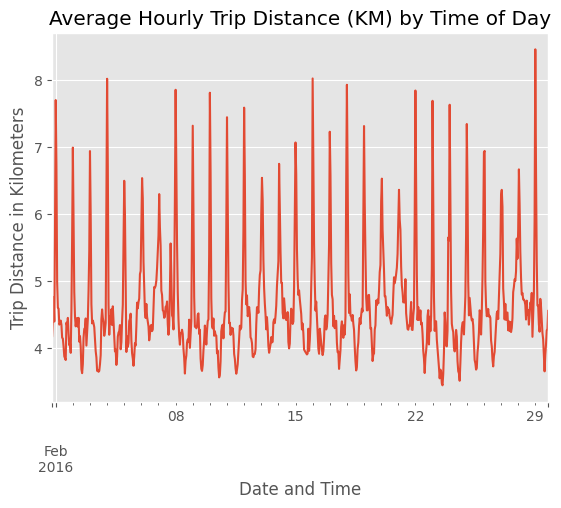

Figure 2: Average Hourly Trip Distance (KM) by Time of Day


In [11]:
datetime_line_plot(trip_data,
                   'trip_distance_km',
                   freq='h',
                   plot_title_name = 'Average Hourly Trip Distance (KM) by Time of Day', 
                   plot_xlabel_name= 'Date and Time', 
                   plot_ylabel_name= 'Trip Distance in Kilometers')
print("Figure 2: Average Hourly Trip Distance (KM) by Time of Day")

We can observe that our trip is somehow stationary, which is what we need to consider when forecasting using ARIMA models. (But this will not be modeled, since the number of trips will be forecasted not the Hourly Distance)

The created `datetime_line_plot` function has a `make_interactive` parameter to look at the line plot in more detail.

In [36]:
datetime_line_plot(trip_data,
                   'trip_distance_km',
                   freq='h',    
                   plot_title_name = 'Average Hourly Trip Distance (KM) by Time of Day', 
                   plot_xlabel_name= 'Date and Time', 
                   plot_ylabel_name= 'Trip Distance in Kilometers',
                   make_interactive=True)
print("Figure 3: Average Hourly Trip Distance (KM) by Time of Day Interactive Plot")

Figure 3: Average Hourly Trip Distance (KM) by Time of Day Interactive Plot


The peak of the chart occurs at 00:00 (midnight), indicating that longer trips tend to happen around midnight each day and the lowest peaks are in the afternoon. The following assumptions have been made:

1. Many people may be taking taxis for longer late night trips, could indicate that many people are using taxis for weekend getaways or business trips during the week days to go to airport from their homes.
2. There are shorter daytime trips, this suggests that taxis are often used for commuting to work, likely for people who live relatively close to their workplaces.
3. Lower average distances per hour on weekends, this may reflect that people tend to stay closer to home, spending time with family rather than traveling long distances (or visit a friend)

## 3. Popular pickup locations on weekdays vs weekends

In [13]:
# extract first the day of week first
trip_data['day_of_week'] = trip_data.index.day_name()
trip_data['day_of_week'].value_counts()

day_of_week
Saturday     274865
Friday       266749
Thursday     212494
Monday       201409
Wednesday    190380
Sunday       186813
Tuesday      178012
Name: count, dtype: int64

In [14]:
WEEK_ENDS = ['Saturday', 'Sunday']

In [15]:
# filter the week days and the week ends
week_ends_mask = trip_data['day_of_week'].isin(WEEK_ENDS)
week_end_trips_data = trip_data[week_ends_mask].copy()
week_day_trips_data = trip_data[~week_ends_mask].copy()

# to check the filtered week end and week day
week_end_trips_data['day_of_week'].unique()
week_day_trips_data['day_of_week'].unique()

array(['Sunday', 'Saturday'], dtype=object)

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [16]:
count_comparison_bar_plot(week_day_trips_data, week_end_trips_data,
                          column_name='PULocationID', df1_name='Weekdays', df2_name='Weekends', 
                          plot_title_name = 'Pickup Locations Count: Weekdays vs Weekends',
                          plot_xlabel_name = "Rank Number",
                          plot_ylabel_name = 'Trip Count')
print("Figure 4: Pickup Locations Count: Weekdays vs Weekends")

Figure 4: Pickup Locations Count: Weekdays vs Weekends


The above plot shows the top 10 most frequent pick up locations. The top 1 is the location ID 75 on weekdays, and location ID 41 for week ends. 
However, the difference between the number of counts of weekdays and weekends is large, this is because weekday has 5 days, and weekend has 2. 
To solve this, we can compute the ratio, then rank the location ID. I can achieve this by adding a parameter `make_ratio = True`

In [17]:
count_comparison_bar_plot(week_day_trips_data, week_end_trips_data,
                          make_ratio=True,
                          column_name='PULocationID', df1_name='Weekdays', df2_name='Weekends', 
                          plot_title_name = 'Pickup Locations Proportion: Weekdays vs Weekends',
                          plot_xlabel_name = "Rank Number",
                          plot_ylabel_name = 'Trip Ratio')
print("Figure 5: Pickup Locations Proportion: Weekdays vs Weekends")


Figure 5: Pickup Locations Proportion: Weekdays vs Weekends


With this, we can say that the top 10 frequent location does not vary significantly and the ranking of the ratio is similar to the count.

In conclusion, designating more taxis to location IDs 75, 41, 74, 7, 166, ..., and 97 on weekdays, and to location IDs 41, 255, 7, 74, 82, ..., and 97 on weekends, could optimize fleet utilization. The higher demand in these areas indicates that deploying more taxis there would likely capture a greater share of trips, leading to increased revenue. By aligning taxi ranking distribution with these demand patterns, the company can more effectively serve passengers and maximize earnings.

The idea of fleet utilization comes from here:
- https://www.way.com/blog/fleet-use-meaning/
- https://www.tourmo.ai/resources/learn/how-to-improve-fleet-utilization-in-3-steps-tm/

## 4. Build a model to forecast the number of trips per hour (ARIMA)


In this modelling process, I will try to implement ARIMA model, and one requirement that we need to satisfy is the stationarity of the data.

We have three ways to measure the stationarity of the data. These are the following:
1. Visual inspection using time-series plot. If we see that we have constant mean and variance, and no seasonality, then we have stationary data. If the visual is hard to visualize, then we go to numbers 2 and 3 below.
2. Using global average tests. In this case, we measure the mean and std of the whole data, then we compute the mean of only a portion of data (For example: Jan to Feb, and the global mean is from Jan to Dec). If we have approximately similar mean and standard deviation, with no seasonality, then we can say that our data is stationary.
3. Using augmented dickey-fuller test. 

This notebook only shows 1 and 3:

In [18]:
datetime_line_plot(trip_data,
                   'trip_distance',
                   freq='h',
                   agg_operation='count',
                   plot_title_name = 'Average Hourly Trip Count by Time of Day', 
                   plot_xlabel_name= 'Date and Time',
                   plot_ylabel_name= 'Number of Trips',
                   make_interactive=True)
print("Figure 6: Average Hourly Trip Count by Time of Day")

Figure 6: Average Hourly Trip Count by Time of Day


Figure 6 shows that the number of trips per hour peaks in the early evening / late afternoon, particularly between 16:00 and 17:00, which aligns with the end of typical working hours. In contrast, the lowest trip counts occur between 20:00 and 01:00, with fewer than a thousand trips during these hours. Based on Figure 3, which displays the average hourly trip distance by time of day, it appears that trips during these low-count hours tend to be longer. This may be due to business-related travel on weekdays or vacation trips on weekends, possibly including trips to the airport. 

Also, since there are peaks that are significantly larger than the other, I think this is non-stationary. To confirm this hypothesis, the augmented dickey-fuller test has been provided:

In [19]:
# get the hourly count
hourly_count_trip_data = trip_data.resample('h').size()
hourly_count_trip_data

lpep_pickup_datetime
2016-01-31 19:00:00-05:00    1290
2016-01-31 20:00:00-05:00     819
2016-01-31 21:00:00-05:00     583
2016-01-31 22:00:00-05:00     431
2016-01-31 23:00:00-05:00     463
                             ... 
2016-02-29 14:00:00-05:00    2814
2016-02-29 15:00:00-05:00    2523
2016-02-29 16:00:00-05:00    2186
2016-02-29 17:00:00-05:00    1765
2016-02-29 18:00:00-05:00    1524
Freq: h, Length: 696, dtype: int64

Confirming the initial assumption of non-stationarity, I calculate the augmented dickey-fuller

In [20]:
adf_result = adfuller(hourly_count_trip_data)
print(f"Test Statistics = {adf_result[0]}\nP-value = {adf_result[1]}")

Test Statistics = -2.511167931620074
P-value = 0.11278063881074313


The augmented dickey-fuller test above shows that our data is non-stationary, since we have a higher p-value (In this case, I will use a 0.05 p-value to reject the null hypothesis). To make the data stationary, we can use differencing:

In [21]:
def get_differencing(data, order=1):
    """
        I think this can be done using recursion
    """
    data = np.array(data)
    differenced_data = [current_point - data[index-1] for index, current_point in enumerate(data) if index != 0]
    
    if order == 1:
        return differenced_data
    elif order > 1:
        order=-1
        return get_differencing(differenced_data, order=order)
    else:
        raise ValueError("Order is invalid")


I coded the above differencing, however, this can be easily achieved in pandas using `diff()` method. (adding two `diff()` methods would result to two levels  of differencing `diff().diff()`.)

In [22]:
diffed_hourly_count_trip_data = hourly_count_trip_data.diff()
diffed_hourly_count_trip_data.head()

lpep_pickup_datetime
2016-01-31 19:00:00-05:00      NaN
2016-01-31 20:00:00-05:00   -471.0
2016-01-31 21:00:00-05:00   -236.0
2016-01-31 22:00:00-05:00   -152.0
2016-01-31 23:00:00-05:00     32.0
Freq: h, dtype: float64

Computing the ADF again:

In [23]:
adf_result = adfuller(diffed_hourly_count_trip_data.fillna(method='bfill')) # I can dropna as well, it doesn't impact the result since it's only one observation
print(f"Test Statistics = {adf_result[0]}\nP-value = {adf_result[1]}")

Test Statistics = -18.567254636314146
P-value = 2.084370026343093e-30


The result now shows stationarity.

In [24]:
datetime_line_plot(diffed_hourly_count_trip_data.to_frame().rename(columns={0: "count"}),
                   "count",
                   plot_title_name = 'Differenced Average Hourly Trip Count by Time of Day', 
                   plot_xlabel_name= 'Date and Time',
                   plot_ylabel_name= 'Differenced Number of Trips',
                   make_interactive=True)
print("Figure 7. Differenced Average Hourly Trip Count by Time of Day")

Figure 7. Differenced Average Hourly Trip Count by Time of Day


The above process shows how we convert the data to stationary, this is important since I can now specify that I only need one differencing to convert the data to stationary, which is useful in parameterizing the ARIMA model. Since I have now the first parameter, I can now look at the ACF and PACF plot for the Moving Average part and the Autoregressive part of the ARIMA model.

**ACF AND PACF Plot**

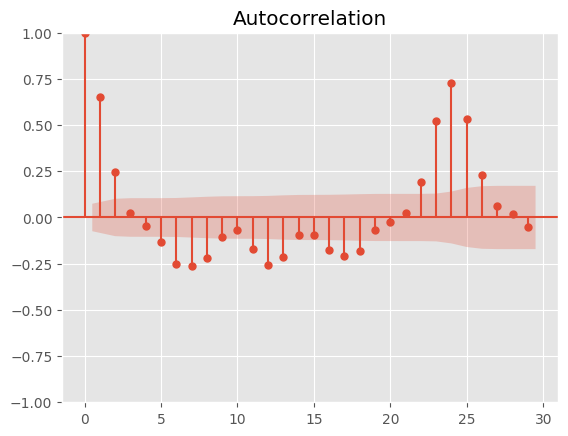

In [25]:
# from statsmodels.api import graphics
sm.graphics.tsa.plot_acf(diffed_hourly_count_trip_data.dropna());

Looking at the ACF plot, we can estimate the order for the moving average part. In this case, since the lag two does show a significant positive correlation and the next lag (lag 3) is not, we can set the moving average part order to 2.

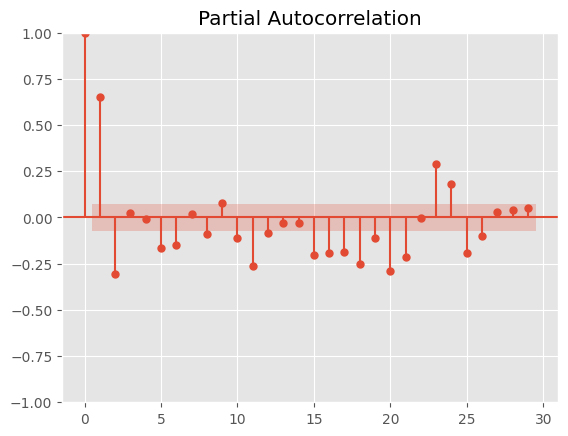

In [26]:
sm.graphics.tsa.plot_pacf(diffed_hourly_count_trip_data.dropna());

For the autoregressive part, I looked at the PACF, similar with the moving average part of the ARIMA model, I can set the order to 2.

Finally, I can set the ARIMA order of (2, 1, 2).

**Looking at the trend, seasonality, and residual.**

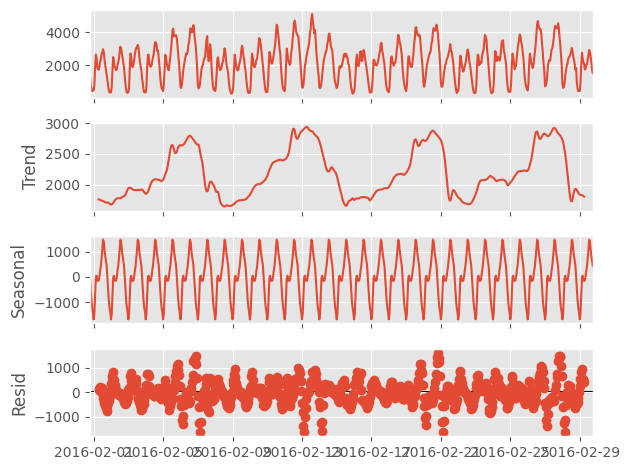

Figure 8. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip


In [27]:
decomposition = sm.tsa.seasonal_decompose(hourly_count_trip_data, model='additive')
fig = decomposition.plot()
plt.show()
print("Figure 8. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip")

Since we have observed that there's a seasonality, I think the model that we can use here is a Seasonal ARIMA. However, due to the time constraints, I cannot observe the seasonal order of the Seasonal ARIMA. However, since we only have February data, I think I can safely avoid using seasonality in this modelling.

Now, for the actual modelling.

In [28]:
model = sm.tsa.arima.ARIMA(hourly_count_trip_data, order=(2,1,2))
fitted_model = model.fit()

In [29]:
num_days = 12

start_index = pd.to_datetime('2016-02-12 10:00:00', utc=True).tz_convert('US/Eastern')
end_index = start_index + pd.DateOffset(days=num_days)
print(f"Forecast from {str(start_index)} to {end_index}")

Forecast from 2016-02-12 05:00:00-05:00 to 2016-02-24 05:00:00-05:00


In [30]:
pred = fitted_model.get_prediction(start=start_index, end=end_index, dynamic=False)
pred_ci = pred.conf_int()

In [31]:
groud_truth_hourly_trip = hourly_count_trip_data[start_index:end_index].to_frame().rename(columns={0: "forecast"})
predicted_values = pred.predicted_mean.to_frame().rename(columns={"predicted_mean": "forecast"})
comparison_line_plot(groud_truth_hourly_trip,
                     predicted_values,
                     column_name="forecast",
                     df1_name="True Values",
                     df2_name="Predicted Values",
                     plot_title_name = '12 Day Forecast: True Values vs Predicted Values', 
                     plot_xlabel_name= 'Date and Time',
                     plot_ylabel_name= 'Forecast')
print("Figure 9. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip")


Figure 9. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip


In Figure 9, we see that the created model can follow the trend of the data. Therefore, I think this is somehow a good (okay) model. However, time-series modelling should also consider statistical assumption to have a better model. Looking at the model summary:


In [32]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  696
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4937.245
Date:                Thu, 19 Sep 2024   AIC                           9884.490
Time:                        19:12:16   BIC                           9907.209
Sample:                    01-31-2016   HQIC                          9893.275
                         - 02-29-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1819      0.200      0.909      0.363      -0.210       0.574
ar.L2         -0.0498      0.122     -0.408      0.684      -0.290       0.190
ma.L1          0.6797      0.202      3.363      0.001       0.284       1.076
ma.L2          0.3272      0.075      4.376      0.000       0.181       0.474
sigma2      8.677e+04   3955.442     21.938      0.000     7.9e+04    9.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.23
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.01
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looking at the summary although the predicted values are following the trend of the true values. Our statistical analysis says that our model is not good. The following are the reason:

1. The ar.L1 and ar.L2 is the p parameter of our ARIMA model (the autoregressive part), since the P>|z| is not small, this could a low impact to the time-series model prediction sinc the coeffients ar part is closer to 0. We need to think of a better way find the best value of the p (autoregressive part) parameter of the model or properly transform our data.

2. The jarque bera p-value is less than 0.05 significance level, which indicates the rejection of the idea that the residual is normally distributed (simply non-distributed residuals). If we implement this model, we wouldn't get a valid confidence interval, coefficient estimates, and p-value.

3. Ljung-Box (L1) is less than 0.05 significance level, which means that our residuals are not independent, which is also an important assumption.


In this case, I think it is safe to asume that ARIMA cannot satify all the assumptions needed (the order that I inferred earlier may not be the optimal order). Other models, data transformations, and order should be considered as well. For now, I will evaluate the developed model.

## 5. Evaluate your forecast model and outcomes using any appropriate measures.

Figure 10. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip


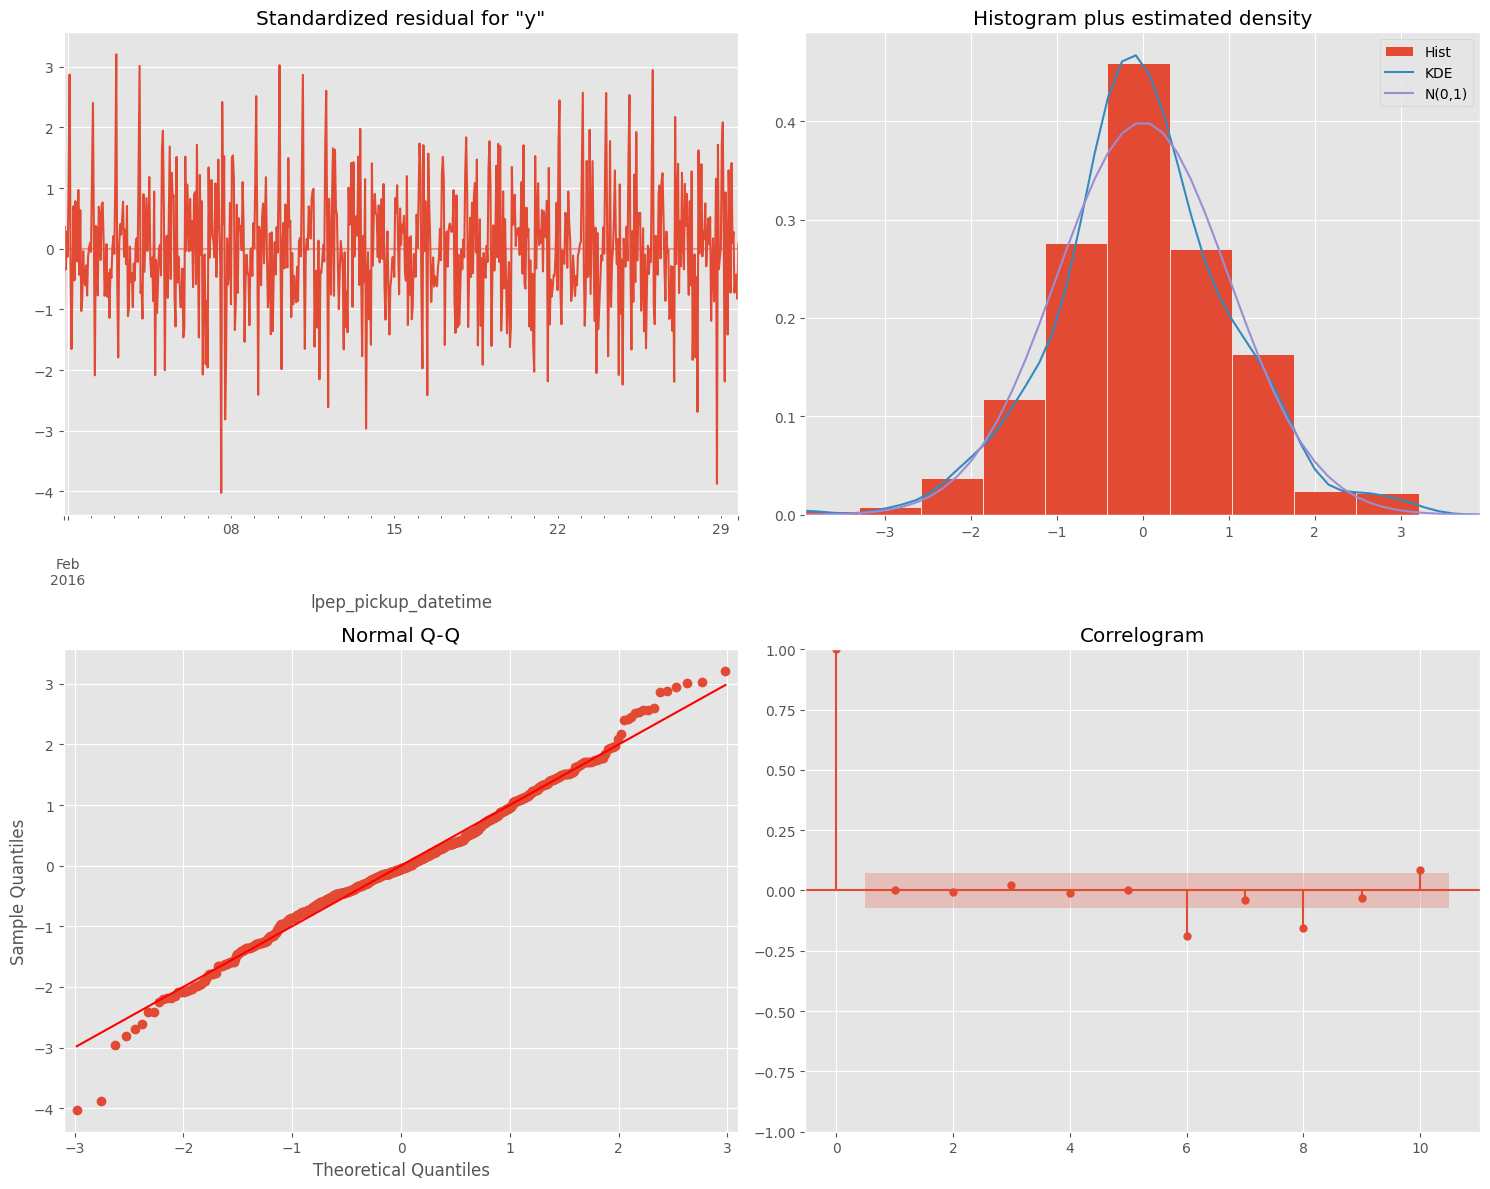

In [33]:
fitted_model.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
print("Figure 10. Observed, Trend, Seasonal, and Residual Plot of the Number of Hourly Trip");

On the top right plot, It has been observed that the blue KDE line is not that close with the N(0,1) curve, which represents a non-normal distribution / non-parameteric distribution. This also supports that our findings looking at the model summary. However, we do not have a long tail, which is a good thing because we can assume that there's no prediction that is very far from the true value. Similar could also be observed in the QQ Plot since we have points that are far away from the line.

**Regression Metrics**

In [34]:

baseline = groud_truth_hourly_trip.mean()
print(f'The baseline: {round(baseline, 2)}')

rmse = np.sqrt(((groud_truth_hourly_trip - predicted_values) ** 2).mean())
print(f'The Mean Squared Error of our forecasts is {round(rmse, 2)}')

mae = abs(groud_truth_hourly_trip - predicted_values).mean()
print(f'The Mean Squared Error of our forecasts is {round(mae, 2)}')

r2 = r2_score(groud_truth_hourly_trip, predicted_values)
print(f'R Squared of our forecasts is {round(r2, 2)}')


The baseline: forecast    2223.02
dtype: float64
The Mean Squared Error of our forecasts is forecast    276.27
dtype: float64
The Mean Squared Error of our forecasts is forecast    217.54
dtype: float64
R Squared of our forecasts is 0.94


Although some statistical tests are not satisfied. The error of the prediction of the model is way lower than the baseline, which is the average count of the hourly trip, which is a good indicator that our model is good at predicting. To support this, the R2 is also provided with 0.94, which means 94% of the variance of the target variable can be explained by the model.


Future improvements:

1. Consider out-of-sample tests and make sure that the model is performing good as well in out-of-sample tests (dynamic prediction)

2. Try other models and other transformations to satisfy the statistical assumptions of the model.

3. Find the most optimal order of ARIMA model or consider Seasonal ARIMA model.

In [35]:
# Optimizing the parameter using grid search

p = range(0, 2)
d = range(1, 2)
q = range(0, 2)

for order in product(p, d, q):
    for seasonal_order in product(range(0, 5), range(0, 2), range(0, 5)):
        mod = sm.tsa.statespace.SARIMAX(hourly_count_trip_data,
                                        order=order,
                                        seasonal_order=(*seasonal_order, 12))
        result = mod.fit(disp=False)
        print(order, seasonal_order, 12)
        print(result.aic)


And that's it for this assessment. You can also access the assessment in my GitHub Repository by clicking this link: https://github.com/Justinjay282/assembly-forecasting